In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import imageio
import scipy
import pandas as pd
from functools import partial

GPU = 1
use_mixed_prec = False

physical_gpus = tf.config.list_physical_devices('GPU')
if physical_gpus:
    try:
        if GPU != "both":
            if GPU == 0:
                os.environ["CUDA_VISIBLE_DEVICES"] = "0"
                # Disable GPU
                tf.config.set_visible_devices(physical_gpus[GPU], 'GPU')
            elif GPU == 1:
                os.environ["CUDA_VISIBLE_DEVICES"] = "1"
                # Disable GPU
                tf.config.set_visible_devices(physical_gpus[GPU], 'GPU')
            if GPU == -1:
                os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
                # Disable GPU
                tf.config.set_visible_devices([], 'GPU')
        visible_gpus = tf.config.get_visible_devices('GPU')
        print("Num Visible Physical GPUs: ", len(physical_gpus),
              "\nNum Visible GPUs Available: ", len(visible_gpus))
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(visible_gpus), "Visible GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)
        
%matplotlib inline
%load_ext autoreload
%autoreload 2
MAP_AUTOTUNE = int(os.cpu_count()*3/4)#tf.data.AUTOTUNE#os.cpu_count()#int(os.cpu_count()*3/4)
AUTOTUNE = tf.data.AUTOTUNE
print('Tensorflow version: ' + tf.__version__)
os.environ['NO_GCE_CHECK'] = 'true'

# For Mixed Precision
from tensorflow.keras import mixed_precision
if use_mixed_prec:
    mixed_precision.set_global_policy('mixed_float16')

Num Visible Physical GPUs:  2 
Num Visible GPUs Available:  1
1 Visible GPUs, 1 Logical GPUs
Tensorflow version: 2.8.0


# Define Func to Get Val Performance

In [41]:
import imageio
import os
import numpy
from pathlib import Path
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
from utils.model_utils import PSNR, SSIM
from utils.augmentation_utils import normalize

def load_image(path):
    # Load Image
    if path.endswith('.npy'):
        img = np.load(path)
    else:
        img = imageio.imread(path)
    return img

def save_image(img, filepath, file_format='.tif'):
    img = np.array(img, dtype=np.float32)
    # Save Image
    if file_format == '.npy':
        new_filepath = Path(filepath)
        new_filepath = new_filepath.with_suffix('')
        new_filepath = new_filepath.with_suffix(file_format)
        np.save(new_filepath, img,
                allow_pickle=True,
                fix_imports=True)
    elif file_format == '.tif' or file_format == '.tiff':
        new_filepath = Path(filepath)
        new_filepath = new_filepath.with_suffix('')
        new_filepath = new_filepath.with_suffix(file_format)
        imageio.imwrite(new_filepath, img)
    else:
        img = (tf.clip_by_value(img, 0, 1).numpy() * 255).astype('uint8')
        new_filepath = Path(filepath)
        new_filepath = new_filepath.with_suffix('')
        new_filepath = new_filepath.with_suffix(file_format)
        imageio.imwrite(new_filepath, img)
        
def apply_model_to_patches(img, model, input_size):
    BUFFER_SIZE = [input_size[0]//64, 
                   input_size[1]//64]
    out_img = np.zeros(img.shape, dtype=np.float32)
    for i in range(0, img.shape[0], input_size[0]):
        patches = []
        for j in range(0, img.shape[1], input_size[1]):
            patch = img[i:i+input_size[0], j:j+input_size[1], :]
            patches.append(patch)
        batch = tf.stack(patches, axis=0)
        pred_batch = model(batch, training=False)
        pred_batch = [pred_batch[k, ...] for k in range(pred_batch.shape[0])]
        pred_batch = np.hstack(pred_batch)
        out_img[i:i+input_size[0], :, :] = pred_batch
    for i in range(input_size[0]//2, img.shape[0] - input_size[0]//2, input_size[0]):
        patches = []
        for j in range(0, img.shape[1], input_size[1]):
            patch = img[i:i+input_size[0], j:j+input_size[1], :]
            patches.append(patch)
        batch = tf.stack(patches, axis=0)
        pred_batch = model(batch, training=False)
        pred_batch = [pred_batch[k, ...] for k in range(pred_batch.shape[0])]
        pred_batch = np.hstack(pred_batch)
        # figsize = (7,7)
        # fig = plt.figure(figsize=figsize)
        # ax = fig.add_axes([0, 0, 1, 1])
        # ax.axis('off')
        # ax.imshow(pred_batch)
        # plt.title('Pred Batch Image')
        # plt.show()
        pred_batch = pred_batch[input_size[0]//2 - BUFFER_SIZE[0]:input_size[0]//2 + BUFFER_SIZE[0], ...]
        out_img[i + input_size[0]//2 - BUFFER_SIZE[0]:i + input_size[0]//2 + BUFFER_SIZE[0], ...] = pred_batch
    for j in range(input_size[1]//2, img.shape[1] - input_size[1]//2, input_size[1]):
        patches = []
        for i in range(0, img.shape[0], input_size[0]):
            patch = img[i:i + input_size[0], j:j + input_size[1], :]
            patches.append(patch)
        batch = tf.stack(patches, axis=0)
        pred_batch = model(batch, training=False)
        pred_batch = [pred_batch[k, ...] for k in range(pred_batch.shape[0])]
        pred_batch = np.vstack(pred_batch)
        # figsize = (7,7)
        # fig = plt.figure(figsize=figsize)
        # ax = fig.add_axes([0, 0, 1, 1])
        # ax.axis('off')
        # ax.imshow(pred_batch)
        # plt.title('Pred Batch Image')
        # plt.show()
        pred_batch = pred_batch[:, input_size[1]//2 - BUFFER_SIZE[1]:input_size[1]//2 + BUFFER_SIZE[1], ...]
        out_img[:, j + input_size[1]//2 - BUFFER_SIZE[1]:j + input_size[1]//2 + BUFFER_SIZE[1], :] = pred_batch
    return out_img

def get_model_performance_stats(model,
                                data_dir, 
                                output_dir, 
                                data_prep_func,
                                file_format=".png",
                                update_freq=20):
    INPUT_SIZE = [256, 256]
    file_list = [file for file in os.listdir(data_dir)
                 if os.path.isfile(os.path.join(data_dir, file))]
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    pred_img_dir = os.path.join(output_dir, "pred_imgs")
    if not os.path.exists(pred_img_dir):
        os.mkdir(pred_img_dir)
    gt_img_dir = os.path.join(output_dir, "gt_imgs")
    if not os.path.exists(gt_img_dir):
        os.mkdir(gt_img_dir)
    in_img_dir = os.path.join(output_dir, "in_imgs")
    if not os.path.exists(in_img_dir):
        os.mkdir(in_img_dir)
    stats = {"filenames": file_list,
             "input_dir": data_dir,
             "output_dir": output_dir,
             "SSIM": [],
             "PSNR": [],
             "MAE": [],
             "MSE": []}
    file_count = 1
    for file in file_list:
        in_path = os.path.join(data_dir, file)
        img = load_image(in_path)
        # Reshape to multiple of 256
        # new_shape = [((img.shape[0] - 1) // 256) * 256, 
        #              ((img.shape[1] - 1) // 256) * 256]
        # print(img.shape)
        # img = tf.image.resize(img, new_shape, method="gaussian", antialias=True)
        new_shape = [int(INPUT_SIZE[0] * np.round(img.shape[0] / INPUT_SIZE[0])),
                     int(INPUT_SIZE[1] * np.round(img.shape[1] / INPUT_SIZE[1]))]
        img = tf.image.resize_with_crop_or_pad(img, new_shape[0], new_shape[1])
        norm_img = normalize(img, clip=False, out_range=[0, 1])
        in_img, gt_img = data_prep_func(norm_img)
        new_filename = os.path.splitext(file)[0] + file_format
        out_path = os.path.join(gt_img_dir, new_filename)
        save_image(gt_img, out_path, file_format)
        new_filename = os.path.splitext(file)[0] + file_format
        out_path = os.path.join(in_img_dir, new_filename)
        save_image(in_img, out_path, file_format)
        # print(gt_img.shape)
        # print(in_img.shape)
        pred_img = apply_model_to_patches(in_img, model, INPUT_SIZE)
        pred_img = normalize(pred_img, clip=False, out_range=[0, 1])
        # print(pred_img.shape)
        new_filename = os.path.splitext(file)[0] + file_format
        out_path = os.path.join(pred_img_dir, new_filename)
        save_image(pred_img, out_path, file_format)
        
        pred_img = pred_img[tf.newaxis, ...]
        gt_img = gt_img[tf.newaxis, ...]
        # print(gt_img.shape)
        # print(pred_img.shape)
        mae = MeanAbsoluteError()(gt_img, pred_img).numpy()
        mse = MeanSquaredError()(gt_img, pred_img).numpy()
        psnr = PSNR(gt_img, pred_img).numpy()[0]
        ssim = SSIM(gt_img, pred_img).numpy()[0]
        stats['MAE'].append(mae)
        stats['MSE'].append(mse)
        stats['PSNR'].append(psnr)
        stats['SSIM'].append(ssim)
        # print(np.mean(np.abs(in_img - gt_img)))
        if np.mean(np.abs(in_img - gt_img)) > 1e-6:
            if file_count == 1:
                stats['JPEG_MAE'] = []
                stats['JPEG_MSE'] = []
                stats['JPEG_SSIM'] = []
                stats['JPEG_PSNR'] = []
            in_img = in_img[tf.newaxis, ...]
            mae = MeanAbsoluteError()(gt_img, in_img).numpy()
            mse = MeanSquaredError()(gt_img, in_img).numpy()
            psnr = PSNR(gt_img, in_img).numpy()[0]
            ssim = SSIM(gt_img, in_img).numpy()[0]
            stats['JPEG_MAE'].append(mae)
            stats['JPEG_MSE'].append(mse)
            stats['JPEG_PSNR'].append(psnr)
            stats['JPEG_SSIM'].append(ssim)
        if file_count == 1:
            print(f'Done with file {file_count} out of {len(file_list)}')
            figsize = (7,7)
            fig = plt.figure(figsize=figsize)
            ax = fig.add_axes([0, 0, 1, 1])
            ax.axis('off')
            ax.imshow(np.squeeze(gt_img))
            plt.title('Ground Truth Image')
            plt.show()
            figsize = (7,7)
            fig = plt.figure(figsize=figsize)
            ax = fig.add_axes([0, 0, 1, 1])
            ax.axis('off')
            ax.imshow(np.squeeze(in_img))
            plt.title('Input Image')
            plt.show()
            figsize = (7,7)
            fig = plt.figure(figsize=figsize)
            ax = fig.add_axes([0, 0, 1, 1])
            ax.axis('off')
            ax.imshow(np.squeeze(pred_img))
            plt.title('Pred Image')
            plt.show()
        elif file_count % update_freq == 0 or file_count == len(file_list):
            print(f'Done with file {file_count} out of {len(file_list)}')
            figsize = (7,7)
            fig = plt.figure(figsize=figsize)
            ax = fig.add_axes([0, 0, 1, 1])
            ax.axis('off')
            ax.imshow(np.squeeze(gt_img))
            plt.title('Ground Truth Image')
            plt.show()
            figsize = (7,7)
            fig = plt.figure(figsize=figsize)
            ax = fig.add_axes([0, 0, 1, 1])
            ax.axis('off')
            ax.imshow(np.squeeze(in_img))
            plt.title('Input Image')
            plt.show()
            figsize = (7,7)
            fig = plt.figure(figsize=figsize)
            ax = fig.add_axes([0, 0, 1, 1])
            ax.axis('off')
            ax.imshow(np.squeeze(pred_img))
            plt.title('Pred Image')
            plt.show()
        file_count += 1
        # print(stats)
    return stats

# Load Saved Model

In [42]:
input_dir = 'saved_unet_gpu1_v1'

In [43]:
input_dir = os.path.join('./trained_models', input_dir)
best_model_dir = os.path.join(input_dir, 'best_models')
file_list = [file for file in os.listdir(best_model_dir) if os.path.isfile(os.path.join(best_model_dir, file))]
filename = sorted(file_list, key = lambda x : int(x.partition('h_')[2].partition('-')[0]))[-1]
path = os.path.join(best_model_dir, filename)
print('Loading Model...')
print(f'Model Path: {path}')
model = tf.keras.models.load_model(path, compile=False)
print('Done!!!')

Loading Model...
Model Path: ./trained_models/saved_unet_gpu1_v1/best_models/saved_model-epoch_199-val_loss_0.02251.h5
Done!!!


In [44]:
model.summary()

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   5824        ['img[0][0]']                    
                                16)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   64         ['conv2d[0][0]']                 
 alization)                     16)                                                            

# Get Val Performance Stats

In [45]:
# def define_in_out(x):
#     return x, x

In [46]:
from utils.jpeg_utils import jpeg_encode_decode
QUALITY = 20#30

def define_in_out(x):
    return jpeg_encode_decode(x, QUALITY), x 

Done with file 1 out of 100


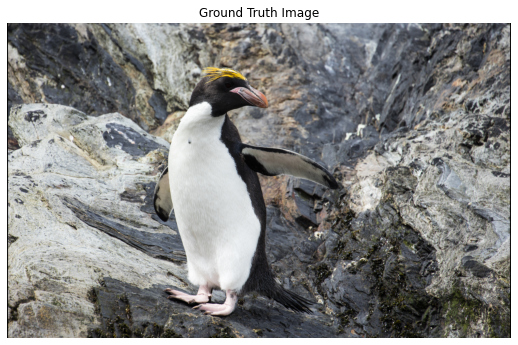

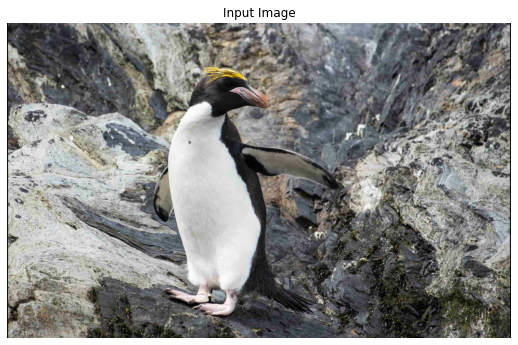

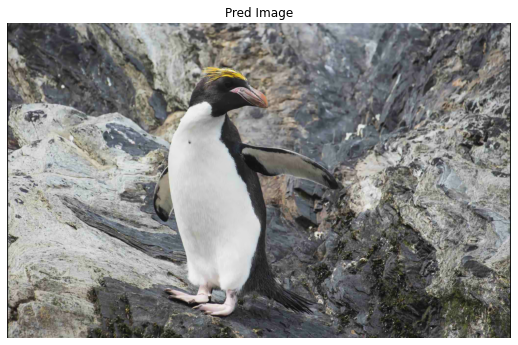

Done with file 20 out of 100


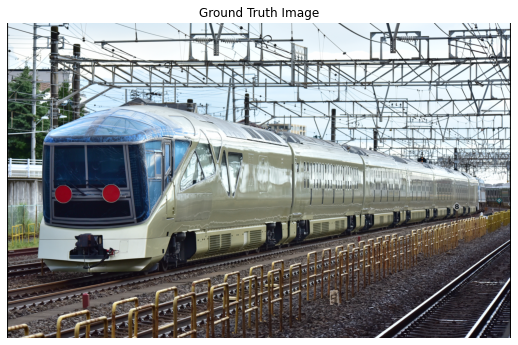

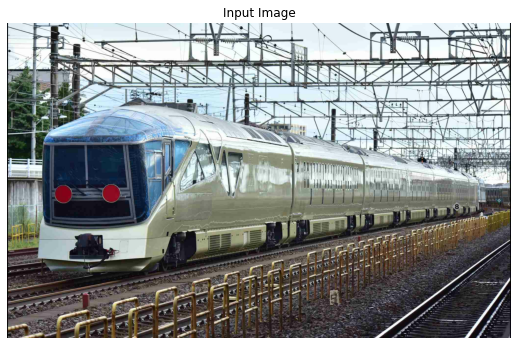

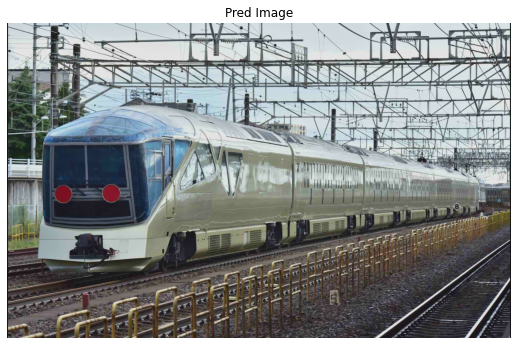

Done with file 40 out of 100


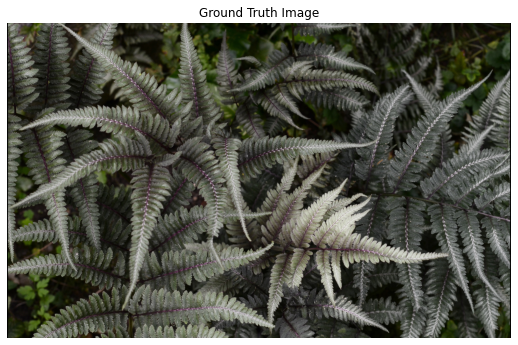

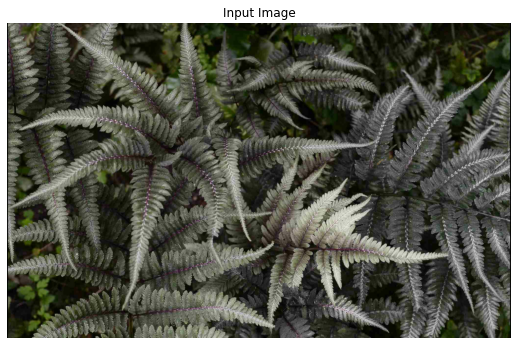

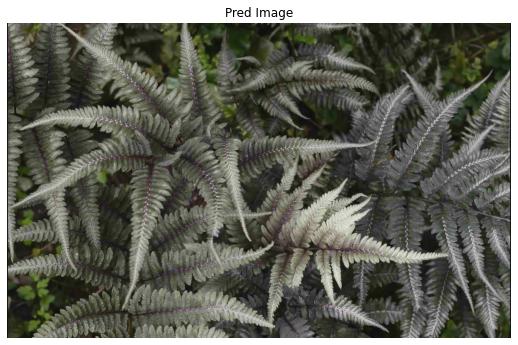

Done with file 60 out of 100


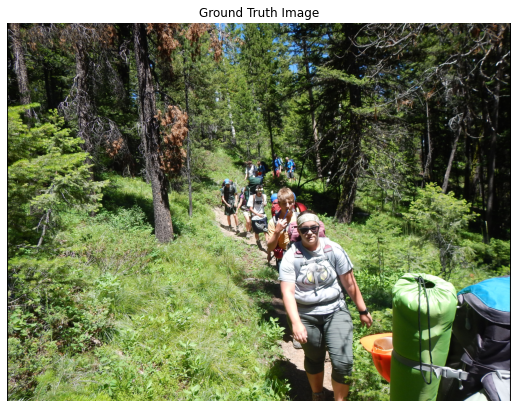

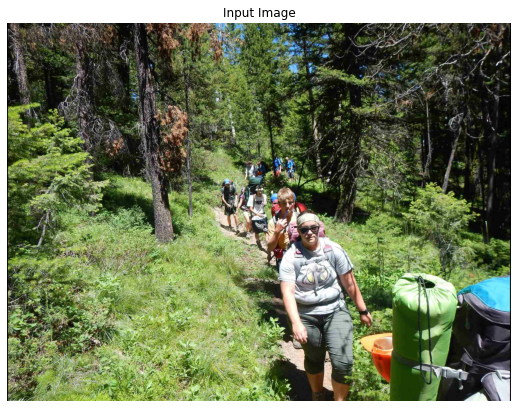

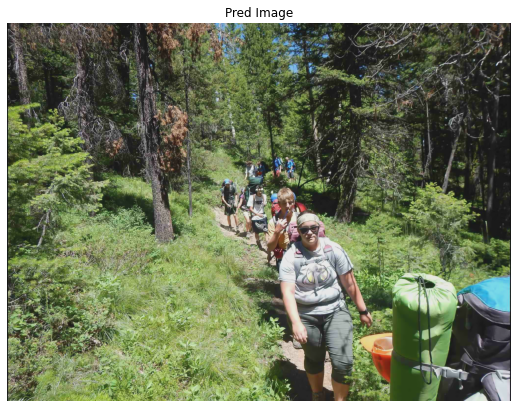

Done with file 80 out of 100


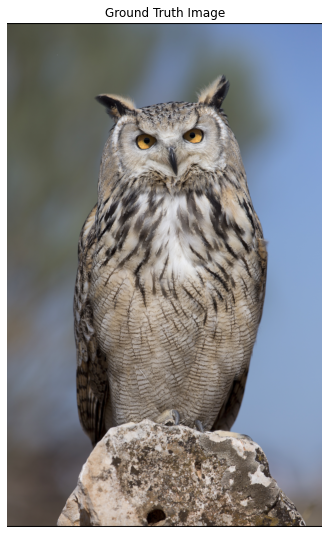

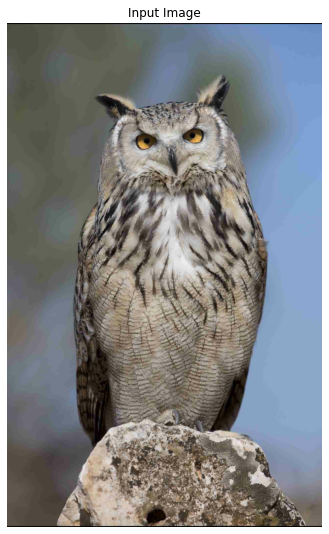

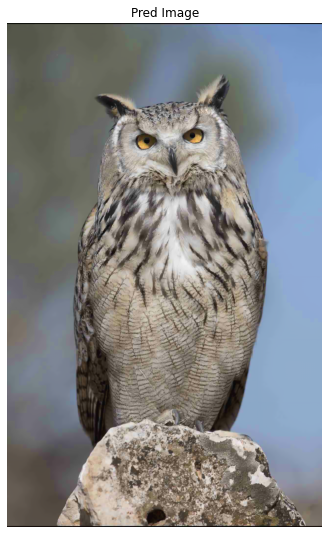

Done with file 100 out of 100


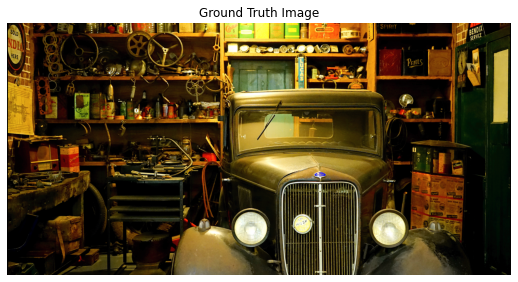

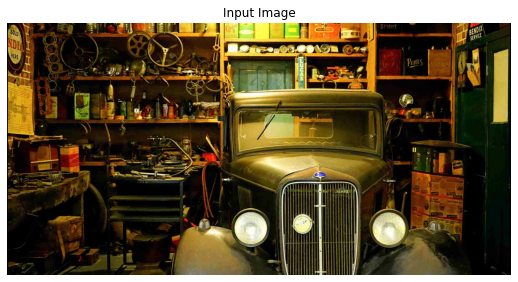

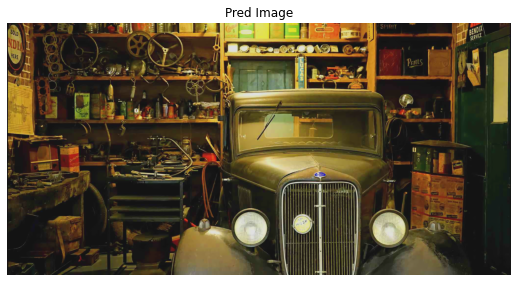

In [47]:
DATA_DIR = "data/val/input"
OUTPUT_DIR = f"stats/{os.path.basename(input_dir)}"
if not os.path.exists("stats"):
    os.mkdir("stats")
stats = get_model_performance_stats(model, DATA_DIR, OUTPUT_DIR, define_in_out)

In [48]:
def print_stats(in_stats, text_file=None,
                exclude_keys=["filenames", "input_dir", "output_dir"]):
    stats = [metric for metric in in_stats.keys()
             if metric not in exclude_keys]
    if text_file is not None:
        for metric in stats:
            print(f'\n--------------{metric}--------------', file=text_file)
            mean = np.mean(np.array(in_stats[metric]))
            stdev = np.std(np.array(in_stats[metric]))
            print(f'{metric} (mean): {mean}', file=text_file)
            print(f'{metric} (sd): {stdev}', file=text_file)
    else:
        for metric in stats:
            print(f'\n--------------{metric}--------------')
            mean = np.mean(np.array(in_stats[metric]))
            stdev = np.std(np.array(in_stats[metric]))
            print(f'{metric} (mean): {mean}')
            print(f'{metric} (sd): {stdev}')

In [49]:
print_stats(stats)
with open(os.path.join(OUTPUT_DIR, "stats_summary.txt"), "w") as f:
    print_stats(stats, text_file=f)
    
# Open the file
with open(os.path.join(OUTPUT_DIR, "model_summary.txt"),'w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: fh.write(x + '\n'))


--------------SSIM--------------
SSIM (mean): 0.8148646354675293
SSIM (sd): 0.09905001521110535

--------------PSNR--------------
PSNR (mean): 25.963909149169922
PSNR (sd): 2.6218509674072266

--------------MAE--------------
MAE (mean): 0.04394640773534775
MAE (sd): 0.014483326114714146

--------------MSE--------------
MSE (mean): 0.003013428533449769
MSE (sd): 0.0018261880613863468

--------------JPEG_MAE--------------
JPEG_MAE (mean): 0.02422397769987583
JPEG_MAE (sd): 0.007905217818915844

--------------JPEG_MSE--------------
JPEG_MSE (mean): 0.0013741030124947429
JPEG_MSE (sd): 0.000943786755669862

--------------JPEG_SSIM--------------
JPEG_SSIM (mean): 0.8448703289031982
JPEG_SSIM (sd): 0.05259723961353302

--------------JPEG_PSNR--------------
JPEG_PSNR (mean): 29.449403762817383
JPEG_PSNR (sd): 2.6753804683685303


In [50]:
stats.keys()

dict_keys(['filenames', 'input_dir', 'output_dir', 'SSIM', 'PSNR', 'MAE', 'MSE'])

In [161]:
img = load_image("data/val/input/0801.png")
img = normalize(img, clip=False, out_range=[0, 1])

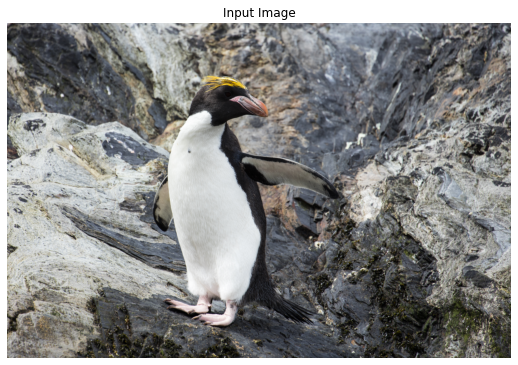

In [162]:
figsize = (7,7)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(img)
plt.title('Input Image')
plt.show()

In [163]:
new_shape = [int(256 * np.ceil(img.shape[0] / 256)),
             int(256 * np.ceil(img.shape[1] / 256))]
in_img = tf.image.resize_with_crop_or_pad(img, new_shape[0], new_shape[1])
block_size = [256, 256]#[new_shape[0]//256, new_shape[1]//256]
test_img = tf.space_to_batch_nd(in_img[None, ...], block_size, paddings=[[0, 0], [0, 0]])

In [164]:
test_img.shape

TensorShape([65536, 6, 8, 3])

In [78]:
img.shape

(1356, 2040, 3)

In [79]:
in_img.shape

TensorShape([1280, 2048, 3])

In [81]:
int(256 * np.round(img.shape[0] / 256))

1280

In [82]:
np.round(img.shape[0] / 256)

5.0

In [93]:
in_img.shape[1]/256

8.0

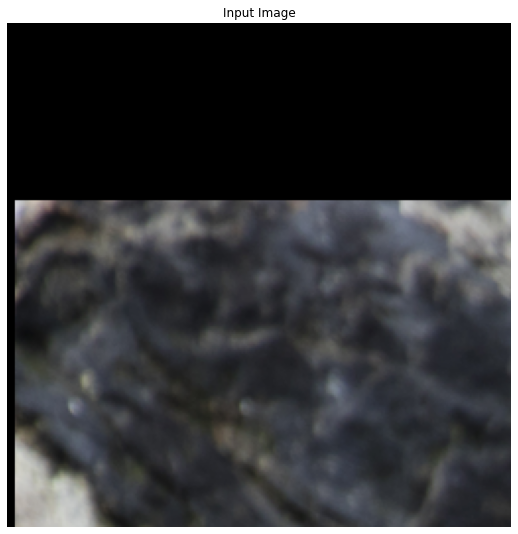

In [165]:
figsize = (7,7)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(np.reshape(test_img[:, 0, 0, :], [256, 256, 3]))
plt.title('Input Image')
plt.show()

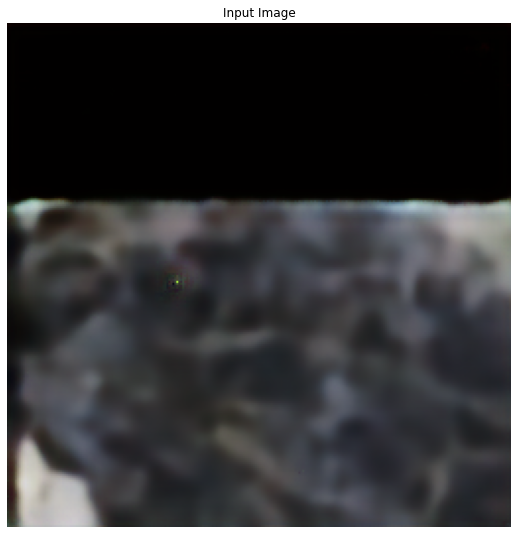

In [169]:
# out_test = model(np.reshape(test_img[:, 0, 0, :], [256, 256, 3])[None,..., None], training=False)
out_test = model(in_img[:256, :256, :][None,...], training=False)
figsize = (7,7)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(np.squeeze(out_test))
plt.title('Input Image')
plt.show()